# HOTPANTS Python Wrapper — JWST JADES Demonstration

This notebook demonstrates the complete capabilities of the **pyhotpants** library using real JWST/NIRCam data from the **JADES (JWST Advanced Deep Extragalactic Survey)** program. 

## About the Data

This example is set up to use an example dataset from the **JADES program, PID 1180**. This demonstration is based on a notebook created for the **JWST Summer School High Redshift Transients with JWST** by: David Coulter (JHU/STScI), Justin Pierel (STScI), Mike Engesser (STScI).

The dataset consists of two F200W NIRCam observations taken at different epochs, which are already aligned using JHAT [https://zenodo.org/badge/latestdoi/575024122] then built into mosaics.

## The HOTPANTS Algorithm

HOTPANTS (Highly Optimized Template Matching and Noise Trimming Subtraction) implements the Alard & Lupton (1998) algorithm for optimal image subtraction. It:

- Models the convolution kernel as a linear combination of basis functions
- Accounts for spatially varying PSF differences between images
- Provides robust error propagation and masking

Let's begin!

## Setup and Imports

In [1]:
# Install HOTPANTS
# !pip install git+https://github.com/zoutei/pyhotpants
# !pip install matplotlib pandas --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

# Import the HOTPANTS Python wrapper
from hotpants import Hotpants, HotpantsConfig

print("Successfully imported all required libraries!")

Successfully imported all required libraries!


## Data Loading and Inspection

Now let's load the JWST/NIRCam F200W data from both epochs. The FITS files contain:
- **Extension 1 (SCI)**: Science data in units of MJy/sr
- **Extension 2 (ERR)**: Error/uncertainty data
- **Extension 0**: Primary header with metadata

We'll also create masks to identify invalid pixels (zeros, NaNs, or negative errors).

In [3]:
# Load Epoch 1 data (template/reference image)
epoch1_file = "data/f200w_epoch1_i2d.fits.fz"

with fits.open(epoch1_file) as hdul:
    hdul.info()

    # Load science data (extension 1) and error data (extension 2)
    epoch1_data = hdul[1].data.astype(np.float32)  # SCI extension
    epoch1_err = hdul[2].data.astype(np.float32)  # ERR extension
    epoch1_header = hdul[1].header.copy()

# Create mask: mark pixels as bad (1) where data is invalid
epoch1_mask = np.where((epoch1_data == 0) | (~np.isfinite(epoch1_data)) | (epoch1_err <= 0) | (~np.isfinite(epoch1_err)), 1, 0).astype(np.int32)

Filename: data/f200w_epoch1_i2d.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     362   ()      
  1  SCI           1 CompImageHDU     78   (2048, 2048)   float32   
  2  ERR           1 CompImageHDU     13   (2048, 2048)   float32   
  3  CON           1 CompImageHDU     10   (2048, 2048, 1)   int32   
  4  WHT           1 CompImageHDU     12   (2048, 2048)   float32   
  5  VAR_POISSON    1 CompImageHDU     12   (2048, 2048)   float32   
  6  VAR_RNOISE    1 CompImageHDU     12   (2048, 2048)   float32   
  7  VAR_FLAT      1 CompImageHDU     12   (2048, 2048)   float32   
  8  HDRTAB        1 BinTableHDU    528   9R x 258C   [23A, 5A, 3A, 41A, 6A, 13A, 6A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 62A, 21A, 3A, 20A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 22A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 15A, 15A, 5A, D, D, D, D, D, D, 27A, D, D, 6A, 5A, 1A, 5A, 5A, 5A, L, 4A, K, 5A, 9A, D, D, D, D, D, D, D, D

In [4]:
epoch2_file = "data/f200w_epoch2_i2d.fits.fz"

with fits.open(epoch2_file) as hdul:
    epoch2_data = hdul[1].data.astype(np.float32)
    epoch2_err = hdul[2].data.astype(np.float32)
    epoch2_header = hdul[1].header.copy()

# Create mask for epoch 2
epoch2_mask = np.where((epoch2_data == 0) | (~np.isfinite(epoch2_data)) | (epoch2_err <= 0) | (~np.isfinite(epoch2_err)), 1, 0).astype(np.int32)

# Verify both images have the same dimensions
assert epoch1_data.shape == epoch2_data.shape, "Images must have the same dimensions!"

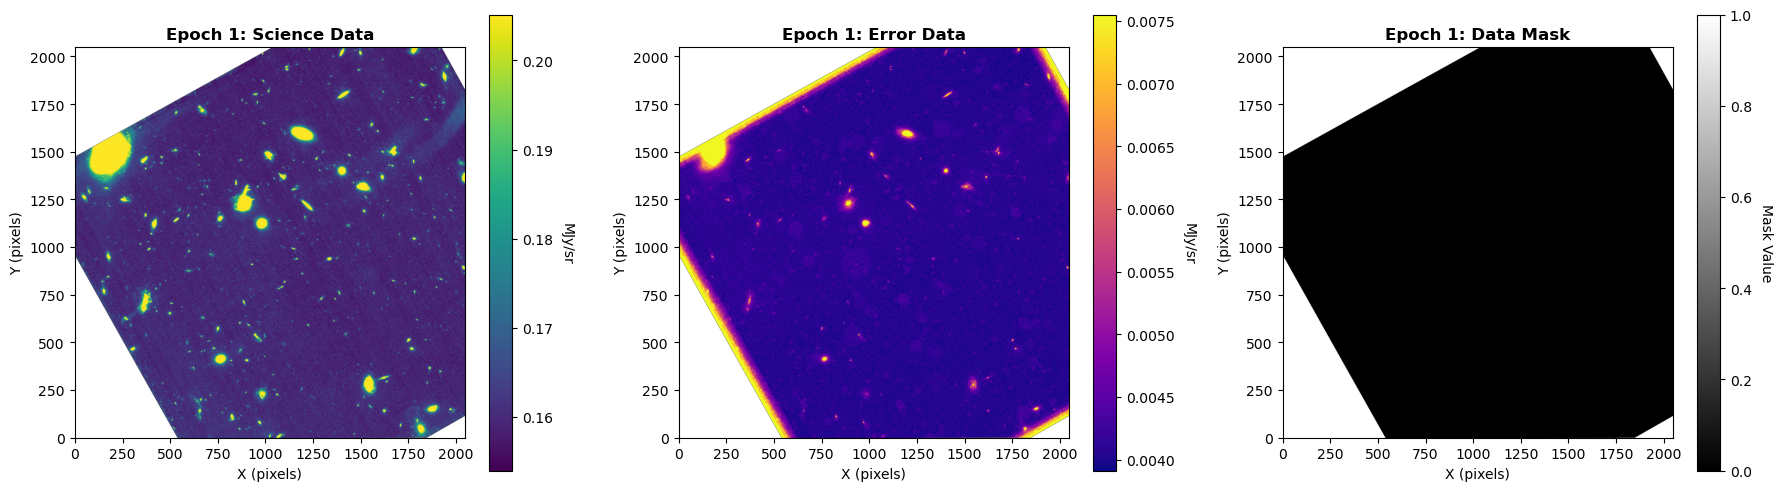

Epoch 1 Statistics:
  Science data median: 1.60e-01
  Error data median: 4.09e-03
  Masked pixels: 583,879 (13.92%)


In [5]:
# Define a helper function for consistent image visualization
def imshow_stretch(data, ax, title, percentiles=(2, 98), cmap="viridis"):
    """
    Display an image with percentile-based scaling for better visualization.

    Parameters:
    -----------
    data : array
        2D image data
    ax : matplotlib axis
        Axis to plot on
    title : str
        Title for the plot
    percentiles : tuple
        Lower and upper percentiles for scaling
    cmap : str
        Colormap name
    """
    finite_data = data[np.isfinite(data)]
    if len(finite_data) > 0:
        vmin, vmax = np.percentile(finite_data, percentiles)
    else:
        vmin, vmax = np.nanmin(data), np.nanmax(data)

    im = ax.imshow(data, origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("MJy/sr" if "Error" not in title and "Mask" not in title else ("MJy/sr" if "Error" in title else "Mask Value"), rotation=270, labelpad=15)

    return im


# Visualize Epoch 1: Data, Error, and Mask
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im1 = imshow_stretch(epoch1_data, axes[0], "Epoch 1: Science Data", cmap="viridis")
im2 = imshow_stretch(epoch1_err, axes[1], "Epoch 1: Error Data", cmap="plasma")
im3 = imshow_stretch(epoch1_mask, axes[2], "Epoch 1: Data Mask", percentiles=(0, 100), cmap="gray")

plt.tight_layout()
plt.show()

print("Epoch 1 Statistics:")
print(f"  Science data median: {np.nanmedian(epoch1_data):.2e}")
print(f"  Error data median: {np.nanmedian(epoch1_err):.2e}")
print(f"  Masked pixels: {np.sum(epoch1_mask):,} ({100 * np.sum(epoch1_mask) / epoch1_mask.size:.2f}%)")

## Star Catalog Loading

For optimal kernel fitting, HOTPANTS needs a catalog of bright, isolated stars. The catalog provides precise positions for substamp extraction and kernel modeling.

In [6]:
# Load the star catalog
catalog_file = "data/f200w_epoch2_i2d.stampxy.txt"
print(f"Loading star catalog from: {catalog_file}")

catalog = pd.read_csv(catalog_file, sep=" ")
catalog_data = catalog[["X", "Y"]].to_numpy()

print(f"Catalog shape: {catalog_data.shape}")


# Show first few entries
print("\nFirst 10 catalog entries:")
print("   X       Y")
print("-" * 15)
for i in range(min(10, len(catalog_data))):
    print(f"{catalog_data[i, 0]:7.1f} {catalog_data[i, 1]:7.1f}")

if len(catalog_data) > 10:
    print(f"... and {len(catalog_data) - 10} more stars")

Loading star catalog from: data/f200w_epoch2_i2d.stampxy.txt
Catalog shape: (560, 2)

First 10 catalog entries:
   X       Y
---------------
  182.3  1491.6
 1397.8  1399.7
 1811.8    49.2
  975.6  1123.6
  762.0   413.7
 1935.5  1893.4
 1196.0  1592.9
  887.3  1228.9
   48.6  1926.9
 1870.9   153.0
... and 550 more stars


## HOTPANTS Configuration

Now we'll set up the HOTPANTS configuration optimized for JWST/NIRCam data. The key parameters are:

### Kernel Parameters
- **`rkernel`**: Convolution kernel half-width
- **`ko`**: Spatial order of kernel variation
- **`bgo`**: Background order

### Stamp Parameters  
- **`nstampx/nstampy`**: Number of stamps per dimension (20×20 grid)
- **`nss`**: Number of substamps per stamp (10 for robust fitting)
- **`rss`**: Substamp half-widths

### Gaussian Basis Functions
HOTPANTS uses multiple Gaussian functions with different widths to model the kernel.

In [7]:
# Define the science image FWHM (typical for JWST/NIRCam F200W)
sci_fwhm = 1.8  # pixels

# Calculate kernel and substamp sizes based on FWHM
kernel_halfwidth = int(2.5 * sci_fwhm + 1)
substamp_halfwidth = int(2.5 * sci_fwhm + 1)

print(f"JWST/NIRCam F200W FWHM: {sci_fwhm} pixels")
print(f"Kernel half-width: {kernel_halfwidth} pixels")
print(f"Substamp half-width: {substamp_halfwidth} pixels")

# Create HOTPANTS configuration with more permissive parameters for JWST
config = HotpantsConfig(
    # Kernel parameters
    rkernel=kernel_halfwidth,  # Convolution kernel half-width
    ko=2,  # Spatial order of kernel variation
    bgo=2,  # Background order
    # Stamp grid parameters
    nstampx=20,  # Number of stamps in X direction
    nstampy=20,  # Number of stamps in Y direction
    nss=10,  # Number of substamps per stamp
    rss=substamp_halfwidth,  # Substamp half-width
    # Gaussian basis function parameters
    ngauss=3,
    deg_fixe=[6, 4, 2],  # Polynomial degrees for each Gaussian
    sigma_gauss=[sci_fwhm / 2.0, sci_fwhm, sci_fwhm * 2.0],  # Gaussian widths
    ks=2.0,  # High sigma rejection for bad stamps in the kernel fit
    kfm=0.9,  # Fraction of absolute kernel sum for a pixel to be considered ‘OK’
    fitthresh=10.0,  # RMS threshold for good centroids in kernel fit
    stat_sig=3.0,  # Threshold for sigma clipping statistics
    # Algorithm control
    force_convolve="t",  # Automatically decide the best image to convolve (b)
    normalize="i",  # Normalize to image
    verbose=0,  # verbosity for debugging
    # Output file names - FITS files will be saved automatically
    output_file="jwst_diff.fits",
    noise_image_file="jwst_diff_noise.fits",
    mask_image_file="jwst_diff_mask.fits",
    convolved_image_file="jwst_diff_convolved.fits",
    sigma_image_file="jwst_diff_sigma.fits",
    stamp_region_file="jwst_stamp_regions.fits",
)

JWST/NIRCam F200W FWHM: 1.8 pixels
Kernel half-width: 5 pixels
Substamp half-width: 5 pixels


## Running the HOTPANTS Pipeline

Now we'll execute the complete HOTPANTS pipeline. This demonstrates the flexibility of the pyhotpants wrapper - you can provide either numpy arrays or FITS filenames as input.



In [8]:
hotpants_demo = Hotpants(
    template_data=epoch1_data,  # Template image (numpy array)
    image_data=epoch2_file,  # Science image (FITS file)
    t_error=epoch1_err,  # Template error array
    i_error=epoch2_err,  # Science error array
    t_mask=epoch1_mask,  # Template mask
    i_mask=epoch2_mask,  # Science mask
    star_catalog=catalog_data,
    config=config,
)

print("✓ HOTPANTS object initialized successfully!")

# Run the complete pipeline
print("\nRunning HOTPANTS pipeline...")

results_demo = hotpants_demo.run_pipeline()

print("✓ Pipeline completed successfully!")
print("\nResults available:")
for key in sorted(results_demo.keys()):
    if isinstance(results_demo[key], np.ndarray):
        print(f"  {key}: {results_demo[key].shape} {results_demo[key].dtype}")
    else:
        print(f"  {key}: {type(results_demo[key]).__name__}")

# The difference image is the main product
diff_image_demo = results_demo["diff_image"]
conv_image_demo = results_demo["convolved_image"]
noise_image_demo = results_demo["noise_image"]
conv_direction = results_demo["conv_direction"]

print("\nDifference image statistics:")
print(f"  Convolution direction: {conv_direction}")
print(f"  Shape: {diff_image_demo.shape}")
print(f"  Range: {np.nanmin(diff_image_demo):.2e} to {np.nanmax(diff_image_demo):.2e}")
print(f"  RMS: {np.nanstd(diff_image_demo):.2e}")
print(f"  Valid pixels: {np.sum(np.isfinite(diff_image_demo))}/{diff_image_demo.size}")

# Store results for later use
results_numpy = results_demo
diff_image_numpy = diff_image_demo
conv_image_numpy = conv_image_demo
noise_image_numpy = noise_image_demo


Initialized HOTPANTS state: <hotpants_ext.HotpantsState object at 0x177fca1f0>
Input mask created with shape: (2048, 2048), dtype: int32
✓ HOTPANTS object initialized successfully!

Running HOTPANTS pipeline...
Using catalog with 560 entries.
Found 138 template stamps and 0 image stamps.


    2.0 sigma clipped mean ksum : 0.979, stdev : 0.191, n : 138


✓ Pipeline completed successfully!

Results available:
  conv_direction: str
  convolved_image: (2048, 2048) float32
  diff_image: (2048, 2048) float32
  fit_stats: dict
  kernel_solution: (301,) float64
  noise_image: (2048, 2048) float32
  output_mask: (2048, 2048) int32
  stats: dict

Difference image statistics:
  Convolution direction: t
  Shape: (2048, 2048)
  Range: -6.66e-01 to 1.24e+00
  RMS: 1.20e-02
  Valid pixels: 4172863/4194304


## Results Visualization

Let's examine the main outputs from the HOTPANTS pipeline. The most important products are:

1. **Difference Image**: Shows the residuals after optimal subtraction
2. **Convolved Image**: The template convolved to match the science PSF  
3. **Noise Image**: Properly propagated uncertainty map
4. **Sigma Image**: Signal-to-noise ratio map (difference/noise)

All outputs are automatically saved as FITS files for further analysis!

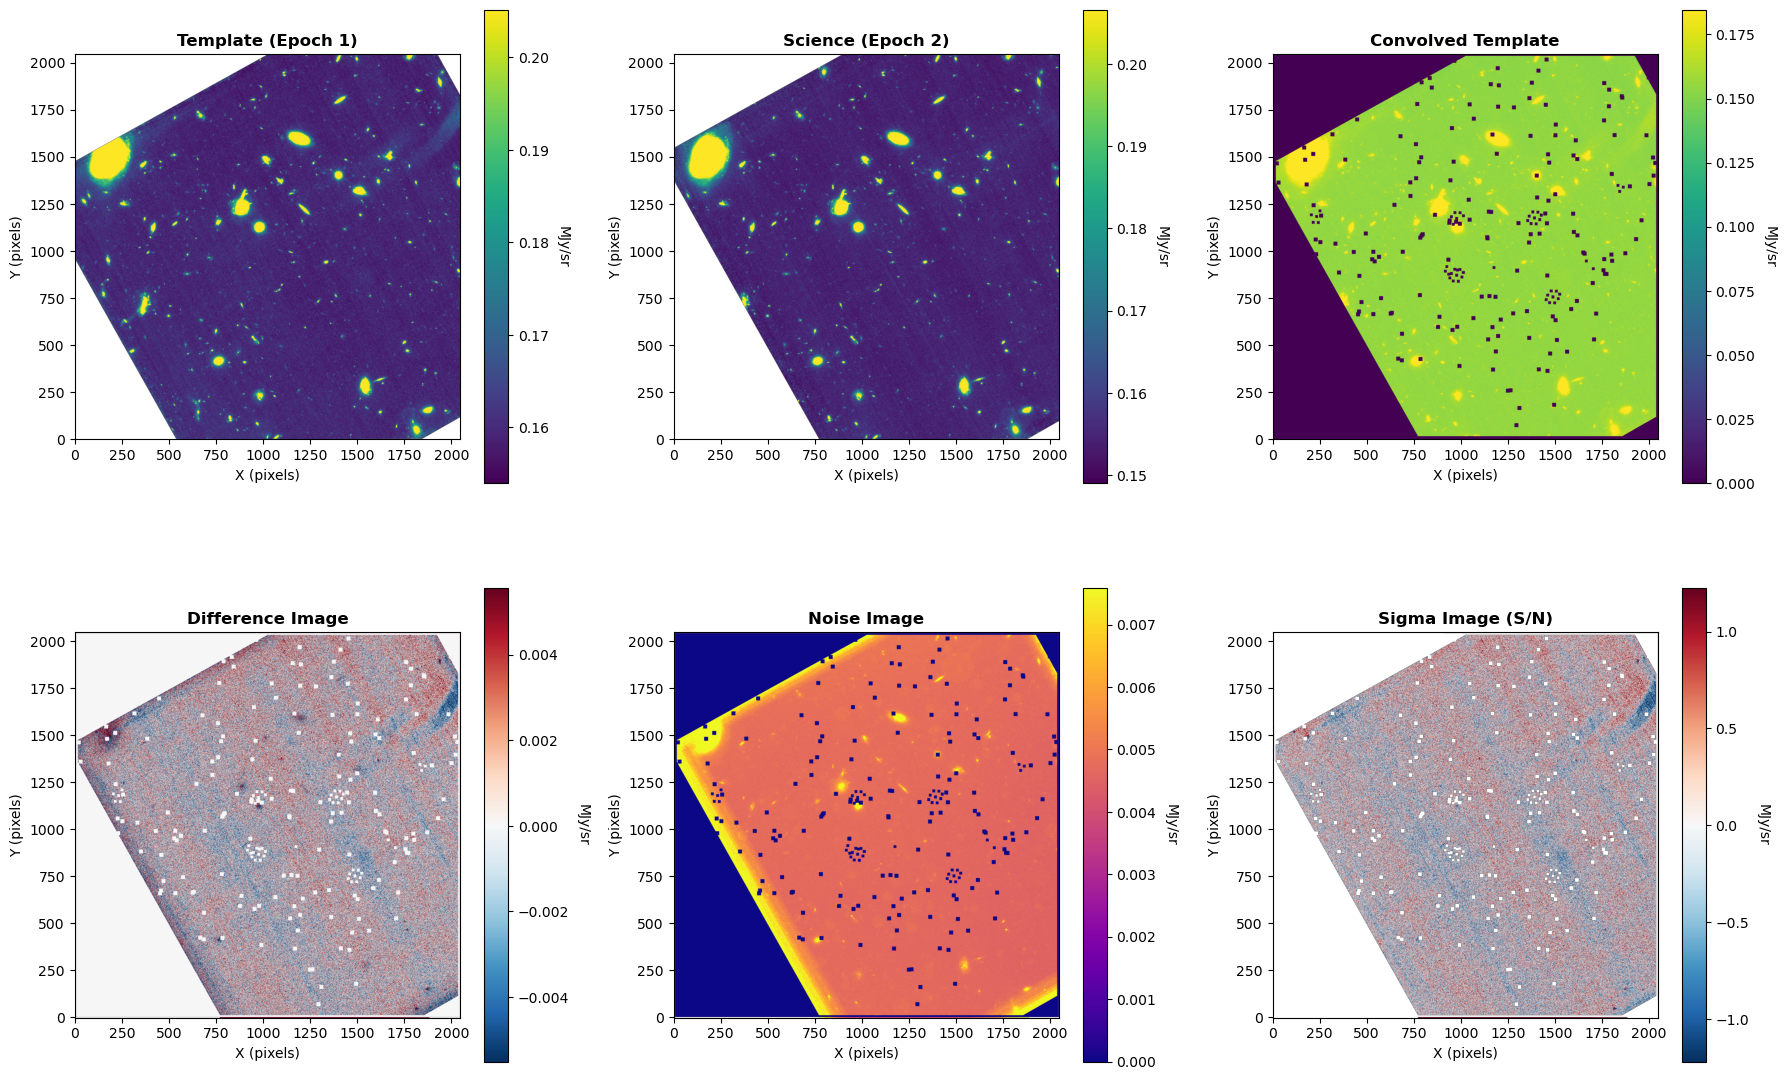

HOTPANTS Results Summary:
Template (Epoch 1):
  Median: 1.60e-01
  RMS: 7.60e-02

Science (Epoch 2):
  Median: 1.55e-01
  RMS: 7.83e-02

Convolved Template:
  Median: 1.54e-01
  RMS: 9.41e-02

Difference Image:
  Median: 1.00e-30
  RMS: 1.20e-02
  5σ threshold: 6.00e-02

Potential 5σ detections: 20287 pixels

✓ All results automatically saved as FITS files:
  • jwst_diff.fits
  • jwst_diff_convolved.fits
  • jwst_diff_noise.fits
  • jwst_diff_sigma.fits
  • jwst_diff_mask.fits
  • jwst_stamp_regions.fits


In [9]:
# Create a comprehensive visualization of the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: Input images
imshow_stretch(epoch1_data, axes[0, 0], "Template (Epoch 1)", cmap="viridis")
imshow_stretch(epoch2_data, axes[0, 1], "Science (Epoch 2)", cmap="viridis")
imshow_stretch(conv_image_numpy, axes[0, 2], "Convolved Template", cmap="viridis")

# Bottom row: Difference products
imshow_stretch(diff_image_numpy, axes[1, 0], "Difference Image", percentiles=(5, 95), cmap="RdBu_r")
imshow_stretch(noise_image_numpy, axes[1, 1], "Noise Image", cmap="plasma")

# Calculate and show sigma image (signal-to-noise)
sigma_image = diff_image_numpy / np.where(noise_image_numpy > 0, noise_image_numpy, np.nan)
imshow_stretch(sigma_image, axes[1, 2], "Sigma Image (S/N)", percentiles=(5, 95), cmap="RdBu_r")

plt.tight_layout()
plt.show()

# Print summary statistics
print("HOTPANTS Results Summary:")
print("=" * 40)
print(f"Template (Epoch 1):")
print(f"  Median: {np.nanmedian(epoch1_data):.2e}")
print(f"  RMS: {np.nanstd(epoch1_data):.2e}")

print(f"\nScience (Epoch 2):")
print(f"  Median: {np.nanmedian(epoch2_data):.2e}")
print(f"  RMS: {np.nanstd(epoch2_data):.2e}")

print(f"\nConvolved Template:")
print(f"  Median: {np.nanmedian(conv_image_numpy):.2e}")
print(f"  RMS: {np.nanstd(conv_image_numpy):.2e}")

print(f"\nDifference Image:")
print(f"  Median: {np.nanmedian(diff_image_numpy):.2e}")
print(f"  RMS: {np.nanstd(diff_image_numpy):.2e}")
print(f"  5σ threshold: {5 * np.nanstd(diff_image_numpy):.2e}")

# Check for potential detections
high_sigma = np.abs(sigma_image) > 5
n_detections = np.sum(high_sigma & np.isfinite(sigma_image))
print(f"\nPotential 5σ detections: {n_detections} pixels")

print(f"\n✓ All results automatically saved as FITS files:")
print(f"  • {config.output_file}")
print(f"  • {config.convolved_image_file}")
print(f"  • {config.noise_image_file}")
print(f"  • {config.sigma_image_file}")
print(f"  • {config.mask_image_file}")
print(f"  • {config.stamp_region_file}")

## Substamp Analysis and Diagnostics

One of the key strengths of the pyhotpants wrapper is its ability to provide detailed diagnostics about the kernel fitting process. Let's examine the substamps used for kernel fitting and their quality metrics.

Substamp Analysis:
Template substamps found: 186

Substamp status distribution:
  USED_IN_FINAL_FIT: 151
  REJECTED_ITERATIVE_FIT: 17
  REJECTED_FOM_CHECK: 18

Quality Metrics:
  FOM values available: 186
  FOM range: 0.004 to 4.947
  FOM median: 0.557
  Substamps used in final fit: 151
  Final fit locations: 151

Kernel Information:
  Convolution direction: t
  Total basis functions: 300
  Kernel half-width: 5 pixels


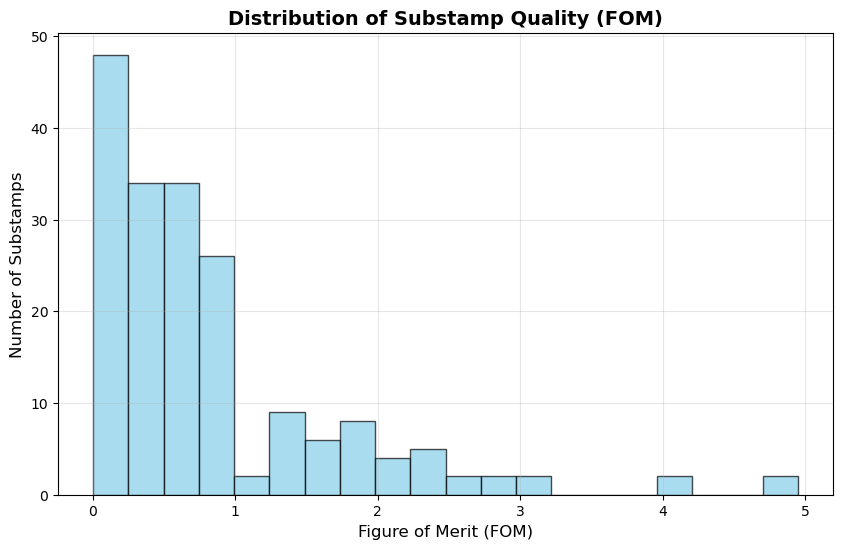

Lower FOM values indicate better quality substamps.


In [10]:
# Get detailed information about substamps
substamp_details = hotpants_demo.get_substamp_details()

print("Substamp Analysis:")
print("=" * 40)

# Analyze template substamps
substamps = substamp_details["template_substamps"] if conv_direction == "t" else substamp_details["image_substamps"]
print(f"Template substamps found: {len(substamps)}")

# Count substamps by status
from collections import Counter

status_counts = Counter([s.status.name for s in substamps])
print(f"\nSubstamp status distribution:")
for status, count in status_counts.items():
    print(f"  {status}: {count}")

# Collect figure-of-merit values for quality assessment
fom_values = []
used_substamps = []

for s in substamps:
    if hasattr(s, "fit_results") and s.fit_results:
        for direction in s.fit_results:
            if "fom" in s.fit_results[direction]:
                fom_values.append(s.fit_results[direction]["fom"])
                if s.status.name == "USED_IN_FINAL_FIT":
                    used_substamps.append(s)

print(f"\nQuality Metrics:")
if fom_values:
    print(f"  FOM values available: {len(fom_values)}")
    print(f"  FOM range: {np.min(fom_values):.3f} to {np.max(fom_values):.3f}")
    print(f"  FOM median: {np.median(fom_values):.3f}")
    print(f"  Substamps used in final fit: {len(used_substamps)}")
else:
    print("  No FOM values available")

# Show final fit statistics
final_fit_info = substamp_details.get("final_fit_locations", {})
if "locations" in final_fit_info:
    print(f"  Final fit locations: {len(final_fit_info['locations'])}")

print(f"\nKernel Information:")
print(f"  Convolution direction: {results_numpy.get('conv_direction', 'Unknown')}")
print(f"  Total basis functions: {config.n_comp_total}")
print(f"  Kernel half-width: {config.rkernel} pixels")

# Plot histogram of FOM values if available
if len(fom_values) > 1:
    plt.figure(figsize=(10, 6))
    plt.hist(fom_values, bins=20, alpha=0.7, color="skyblue", edgecolor="black")
    plt.xlabel("Figure of Merit (FOM)", fontsize=12)
    plt.ylabel("Number of Substamps", fontsize=12)
    plt.title("Distribution of Substamp Quality (FOM)", fontsize=14, fontweight="bold")
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Lower FOM values indicate better quality substamps.")
else:
    print("Insufficient FOM data for histogram.")

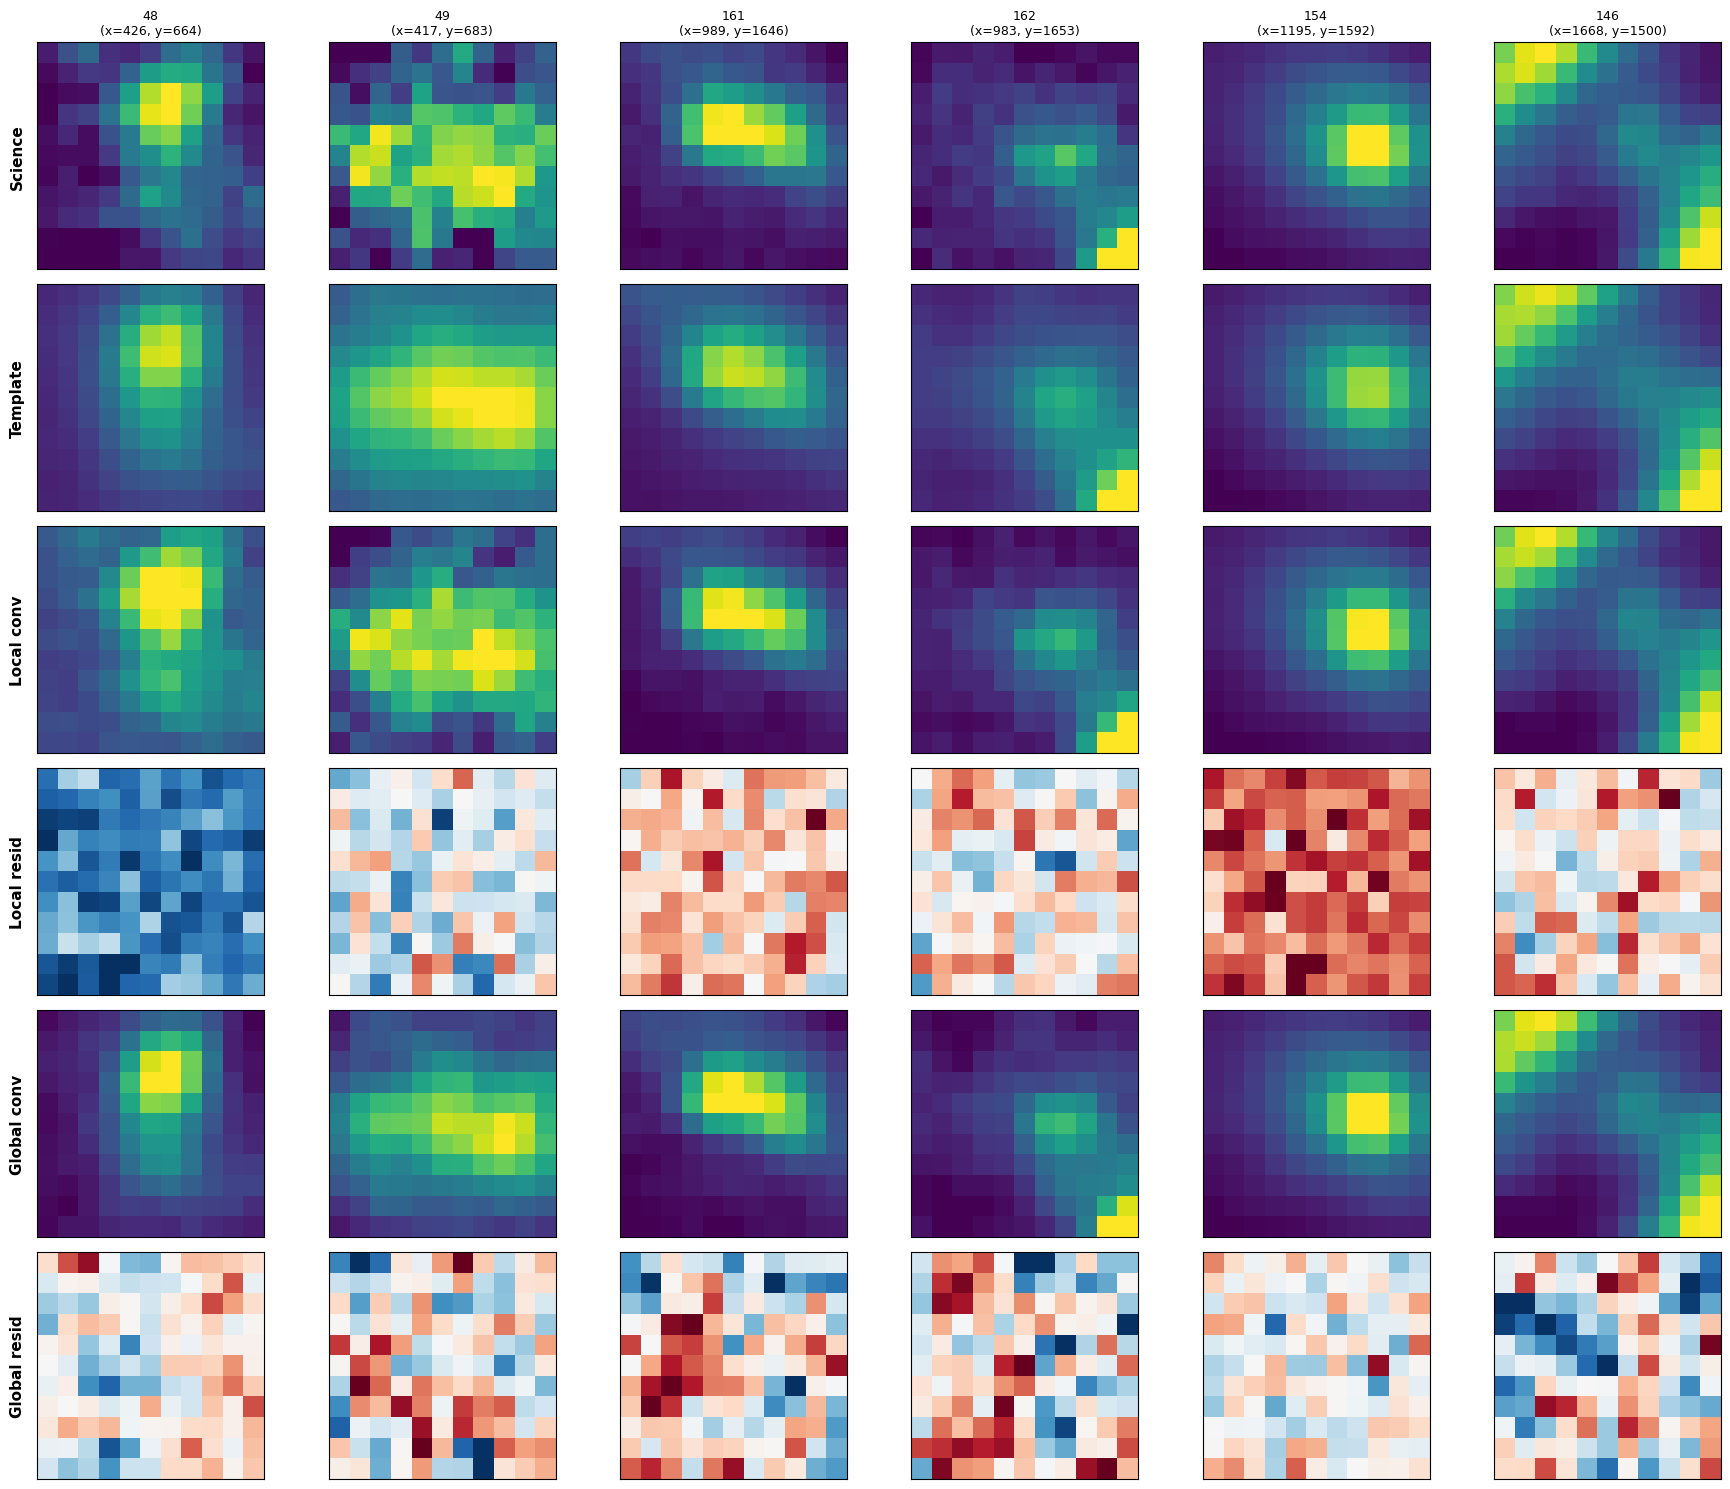

In [11]:
# Visualize six panels (science, template, local conv, local residual, global conv, global residual)

n_substamps = min(6, len(used_substamps))  # show 6 best substamps

used_substamps.sort(key=lambda s: s.fit_results[conv_direction]["fom"] if (hasattr(s, "fit_results") and s.fit_results and conv_direction in s.fit_results and "fom" in s.fit_results[conv_direction]) else np.inf)

if n_substamps == 0:
    print("No high-quality substamps available for visualization.")

panel_names = ["Science", "Template", "Local conv", "Local resid", "Global conv", "Global resid"]
n_panels = len(panel_names)

fig, axes = plt.subplots(n_panels, n_substamps, figsize=(3.0 * n_substamps, 2.5 * n_panels), squeeze=False)

for col, substamp in enumerate(used_substamps[:6]):
    # extract cutouts (template & science)
    hw = config.rss
    x, y = int(substamp.x), int(substamp.y)

    template_cutout = substamp.template_cutout
    image_cutout = substamp.image_cutout
    convolved_model_local = substamp.convolved_model_local
    convolved_model_global = substamp.convolved_model_global

    local_resid = image_cutout - convolved_model_local
    global_resid = image_cutout - convolved_model_global

    # scaling: intensity panels share vmin/vmax from template/image/conv
    combined = np.concatenate([template_cutout.ravel(), image_cutout.ravel(), convolved_model_local.ravel(), convolved_model_global.ravel()])
    finite = combined[np.isfinite(combined)]
    vmin, vmax = np.percentile(finite, [2, 98])

    # residual scaling: symmetric around zero
    combined_res = np.concatenate([local_resid.ravel(), global_resid.ravel()])
    finite_res = combined_res[np.isfinite(combined_res)]
    rmax = np.nanpercentile(np.abs(finite_res), 98)
    rmin, rmax = -rmax, rmax

    # Plot each row (panel)
    axs = axes[:, col]

    im = axs[0].imshow(image_cutout, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axs[0].set_title(f"{substamp.id if hasattr(substamp, 'id') else col + 1}\n(x={substamp.x:.0f}, y={substamp.y:.0f})", fontsize=9)
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].imshow(template_cutout, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    axs[2].imshow(convolved_model_local, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    axs[3].imshow(local_resid, origin="lower", cmap="RdBu_r", vmin=rmin, vmax=rmax)
    axs[3].set_xticks([])
    axs[3].set_yticks([])

    axs[4].imshow(convolved_model_global, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    axs[4].set_xticks([])
    axs[4].set_yticks([])

    axs[5].imshow(global_resid, origin="lower", cmap="RdBu_r", vmin=rmin, vmax=rmax)
    axs[5].set_xticks([])
    axs[5].set_yticks([])

    # # add a small colorbar on top column only to avoid clutter
    # if col == 0:
    #     fig.colorbar(im, ax=axs[0], shrink=0.7, label="MJy/sr")
    #     fig.colorbar(plt.cm.ScalarMappable(cmap="RdBu_r"), ax=axs[3], shrink=0.7, label="Residual")

# Set row labels (left-most column)
for row in range(n_panels):
    axes[row, 0].text(-0.12, 0.5, panel_names[row], transform=axes[row, 0].transAxes, fontsize=11, fontweight="bold", va="center", rotation=90)

plt.tight_layout()
plt.show()

## Kernel Basis Functions

The HOTPANTS algorithm models the convolution kernel using a set of basis functions. These are typically Gaussian functions with different widths and polynomial modulations. Let's visualize these basis functions for one of our substamps.

Examining basis functions for substamp at (426, 664)
Number of basis functions: 55
Basis function size: 11×11 pixels


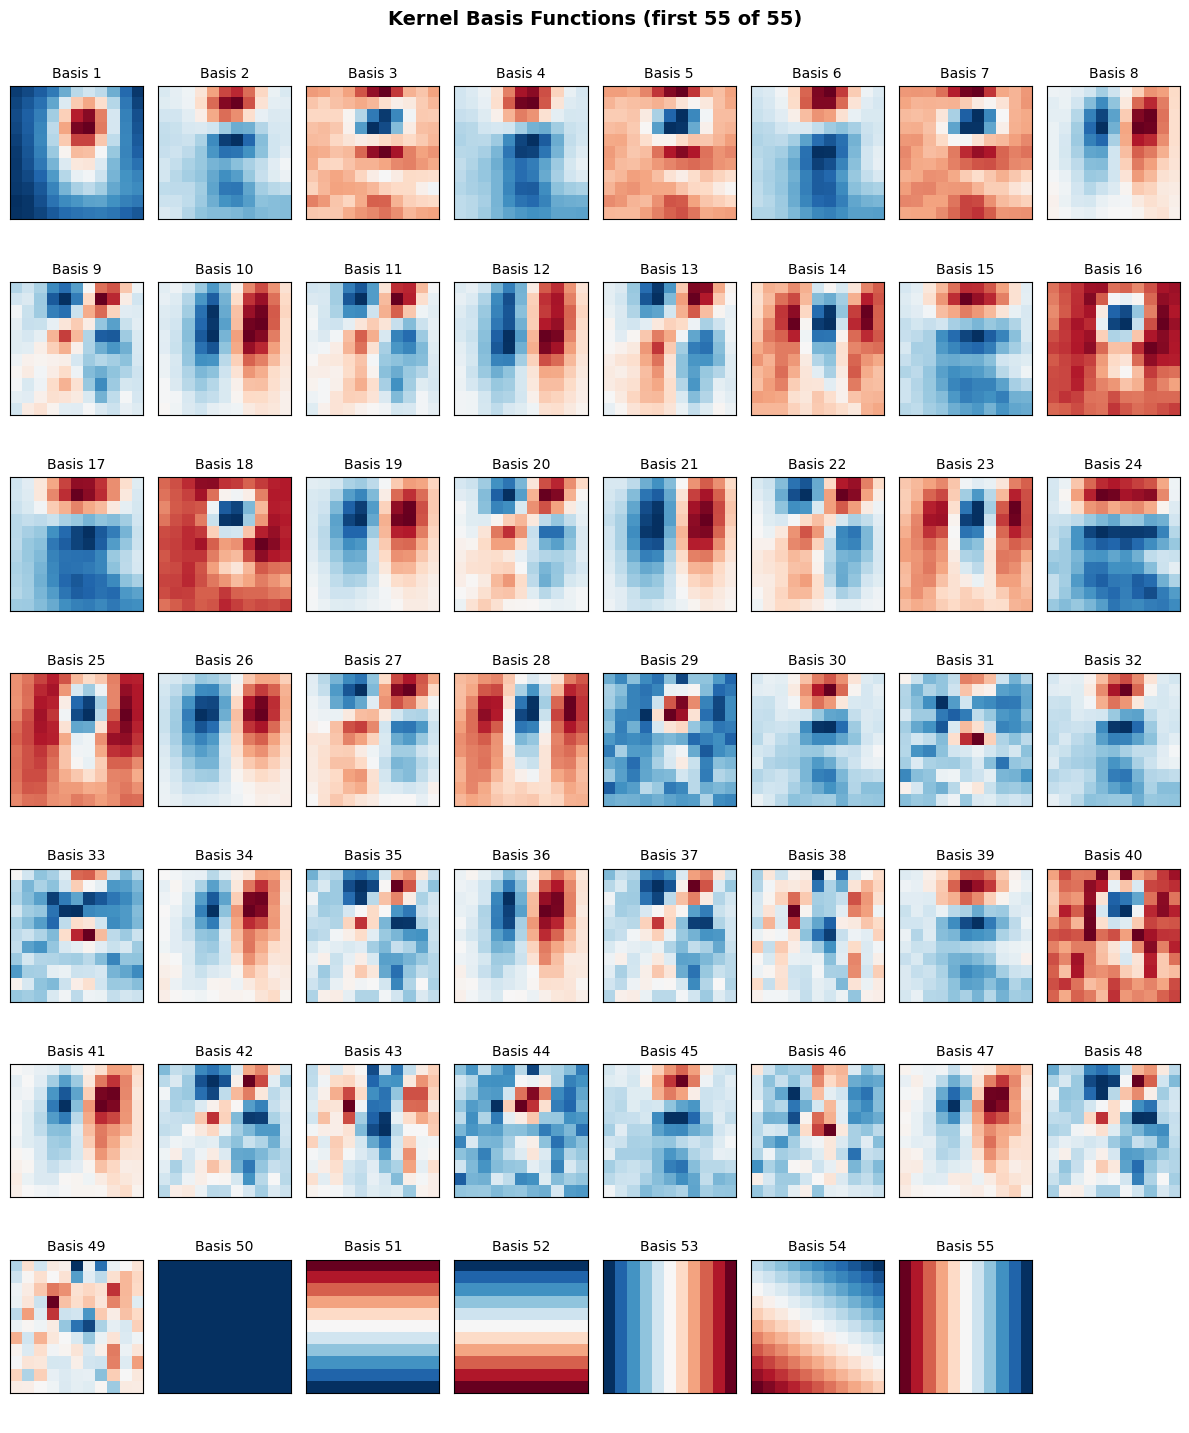


Basis Function Details:
  Total functions: 55
  Gaussian components: 3
  Polynomial degrees: [6, 4, 2]
  Gaussian sigmas: [0.7, 1.5, 3.0]


In [12]:
# Visualize basis functions for a selected substamp
if len(used_substamps) > 0:
    # Select the first good substamp
    selected_substamp = used_substamps[0]

    print(f"Examining basis functions for substamp at ({selected_substamp.x:.0f}, {selected_substamp.y:.0f})")

    if hasattr(selected_substamp, "basis_vectors") and selected_substamp.basis_vectors is not None:
        basis_vectors = selected_substamp.basis_vectors
        n_basis = basis_vectors.shape[0]

        print(f"Number of basis functions: {n_basis}")
        print(f"Basis function size: {basis_vectors.shape[1]}×{basis_vectors.shape[2]} pixels")

        n_display = n_basis
        n_cols = 8
        n_rows = (n_display + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)

        for i in range(n_display):
            row = i // n_cols
            col = i % n_cols

            ax = axes[row, col]
            basis_func = basis_vectors[i]

            # # Use symmetric colormap for basis functions
            # vmax = np.max(np.abs(basis_func))
            # vmin = -vmax

            im = ax.imshow(basis_func, origin="lower", cmap="RdBu_r")
            ax.set_title(f"Basis {i + 1}", fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])

            # Add small colorbar
            # cbar = plt.colorbar(im, ax=ax, shrink=0.8)
            # cbar.ax.tick_params(labelsize=8)

        # Hide unused subplots
        for i in range(n_display, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].axis("off")

        plt.tight_layout()
        plt.suptitle(f"Kernel Basis Functions (first {n_display} of {n_basis})", fontsize=14, fontweight="bold", y=1.02)
        plt.show()

        print(f"\nBasis Function Details:")
        print(f"  Total functions: {n_basis}")
        print(f"  Gaussian components: {config.ngauss}")
        print(f"  Polynomial degrees: {config.deg_fixe}")
        print(f"  Gaussian sigmas: {config.sigma_gauss}")

    else:
        print("No basis vectors available for this substamp.")

else:
    print("No substamps available for basis function analysis.")

## Kernel Visualization  

The final convolution kernel varies spatially across the image to account for PSF variations. Let's visualize the kernel at a few different locations to see how it changes.

Visualizing kernels at different image locations:
  Lower Left: Kernel range [-0.444, 0.444]
  Lower Right: Kernel range [-0.444, 0.444]
  Center: Kernel range [-0.444, 0.444]
  Upper Left: Kernel range [-0.444, 0.444]
  Upper Right: Kernel range [-0.444, 0.444]


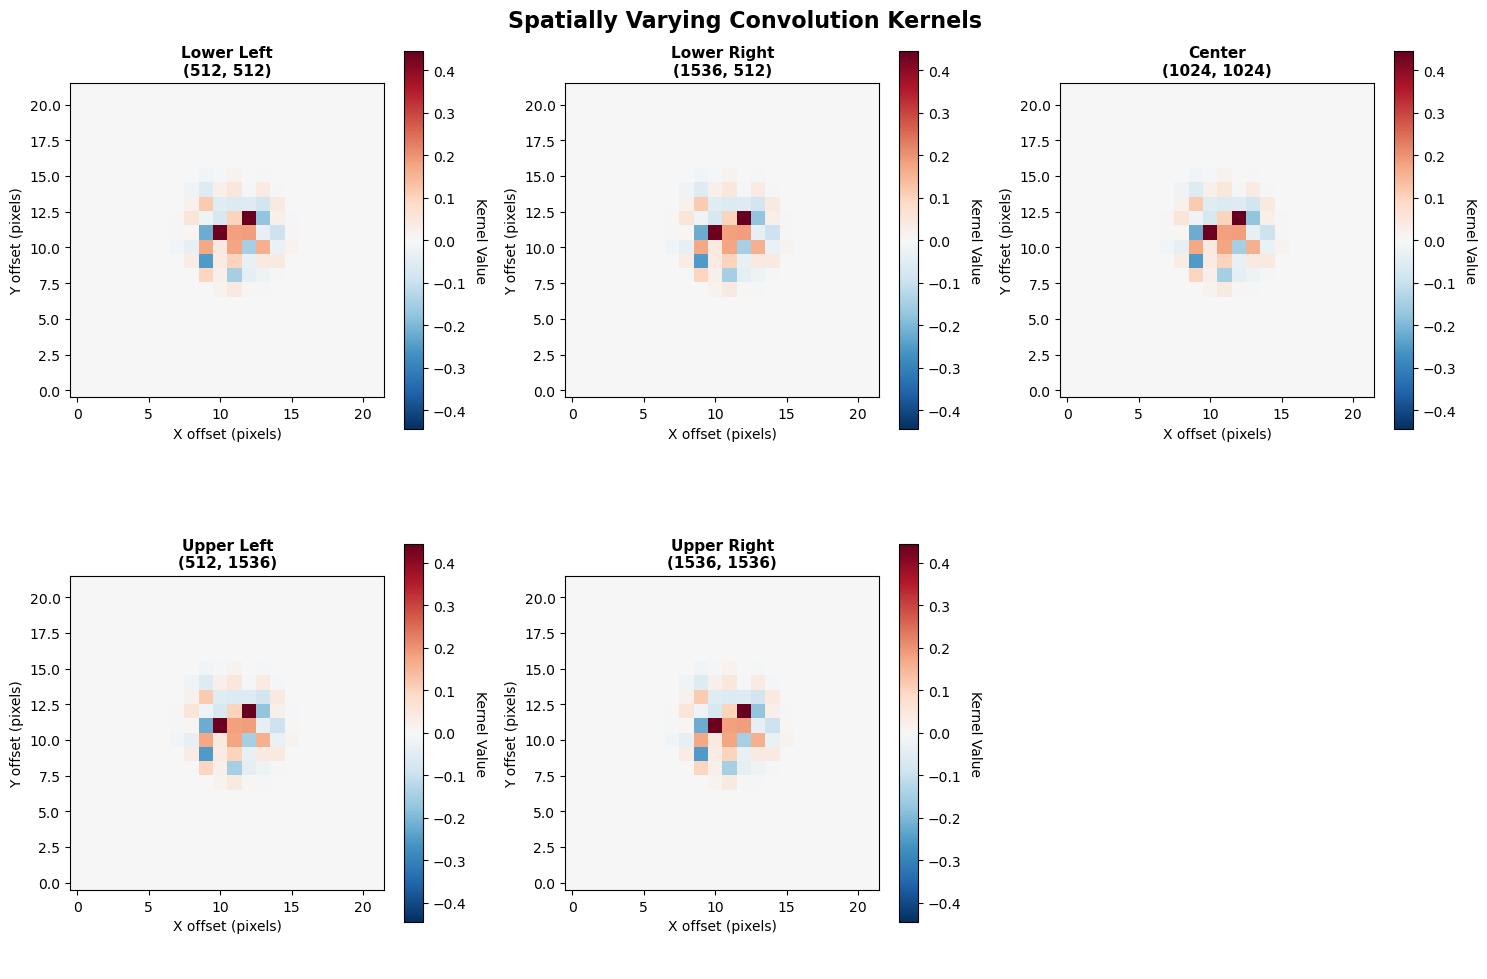


Kernel Properties:
  Kernel half-width: 5 pixels
  Full kernel size: 11×11 pixels
  Spatial variation order: 2
  Number of basis functions: 300

✓ The kernels show spatial variation across the image,
  accounting for PSF differences between the template and science images.


In [13]:
# Visualize the kernel at different locations across the image
kernel_locations = [
    (epoch2_data.shape[1] // 4, epoch2_data.shape[0] // 4),  # Lower left
    (3 * epoch2_data.shape[1] // 4, epoch2_data.shape[0] // 4),  # Lower right
    (epoch2_data.shape[1] // 2, epoch2_data.shape[0] // 2),  # Center
    (epoch2_data.shape[1] // 4, 3 * epoch2_data.shape[0] // 4),  # Upper left
    (3 * epoch2_data.shape[1] // 4, 3 * epoch2_data.shape[0] // 4),  # Upper right
]

location_names = ["Lower Left", "Lower Right", "Center", "Upper Left", "Upper Right"]

print("Visualizing kernels at different image locations:")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (location, name) in enumerate(zip(kernel_locations, location_names)):
    try:
        # Get kernel visualization at this location
        kernel_vis = hotpants_demo.visualize_kernel(location, size_factor=2.0)

        ax = axes[i]

        # Use symmetric scaling around zero
        vmax = np.max(np.abs(kernel_vis))
        vmin = -vmax

        im = ax.imshow(kernel_vis, origin="lower", cmap="RdBu_r", vmin=vmin, vmax=vmax)
        ax.set_title(f"{name}\n({location[0]}, {location[1]})", fontsize=11, fontweight="bold")
        ax.set_xlabel("X offset (pixels)")
        ax.set_ylabel("Y offset (pixels)")

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label("Kernel Value", rotation=270, labelpad=15)

        print(f"  {name}: Kernel range [{vmin:.3f}, {vmax:.3f}]")

    except Exception as e:
        print(f"  Could not generate kernel for {name}: {e}")
        axes[i].text(0.5, 0.5, f"Error\n{name}", ha="center", va="center", transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Hide the last subplot if we have fewer than 6 kernels
axes[-1].axis("off")

plt.tight_layout()
plt.suptitle("Spatially Varying Convolution Kernels", fontsize=16, fontweight="bold", y=0.98)
plt.show()

print(f"\nKernel Properties:")
print(f"  Kernel half-width: {config.rkernel} pixels")
print(f"  Full kernel size: {2 * config.rkernel + 1}×{2 * config.rkernel + 1} pixels")
print(f"  Spatial variation order: {config.ko}")
print(f"  Number of basis functions: {config.n_comp_total}")

print(f"\n✓ The kernels show spatial variation across the image,")
print(f"  accounting for PSF differences between the template and science images.")

## Step-by-Step Pipeline Execution

The pyhotpants wrapper also allows you to execute the pipeline step-by-step for detailed analysis and debugging. This is useful for understanding the algorithm or optimizing parameters.

In [14]:
# Create a new HOTPANTS instance for step-by-step demonstration
print("Creating new HOTPANTS instance for step-by-step execution...")

hotpants_stepwise = Hotpants(
    template_data=epoch1_data,
    image_data=epoch2_data,
    t_error=epoch1_err,
    i_error=epoch2_err,
    t_mask=epoch1_mask,
    i_mask=epoch2_mask,
    star_catalog=catalog_data,
    config=config,
)

print("✓ Step-by-step HOTPANTS instance created")

# Step 1: Find stamps
print("\nStep 1: Finding stamps...")
print("-" * 30)
t_stamps, i_stamps = hotpants_stepwise.find_stamps()
print(f"Found {len(t_stamps)} template stamps and {len(i_stamps)} image stamps")

# Step 2: Fit and select direction
print("\nStep 2: Fitting stamps and selecting convolution direction...")
print("-" * 30)
conv_direction = hotpants_stepwise.fit_and_select_direction()
print(f"Selected convolution direction: {'Template' if conv_direction == 't' else 'Image'}")

# Step 3: Iterative fitting and clipping
print("\nStep 3: Solving global kernel with iterative clipping...")
print("-" * 30)
kernel_solution, final_fits = hotpants_stepwise.iterative_fit_and_clip()
print(f"Kernel solution has {len(kernel_solution)} coefficients")
print(f"Final fit uses {len(final_fits)} high-quality substamps")

# Step 4: Convolution and differencing
print("\nStep 4: Applying kernel and creating difference image...")
print("-" * 30)
diff_img, conv_img, noise_img, mask_img = hotpants_stepwise.convolve_and_difference()
print(f"Difference image created with shape: {diff_img.shape}")
print(f"RMS of difference: {np.nanstd(diff_img):.2e}")

# Step 5: Get final outputs
print("\nStep 5: Collecting final outputs and statistics...")
print("-" * 30)
final_outputs = hotpants_stepwise.get_final_outputs()
print(f"Final outputs contain: {list(final_outputs.keys())}")

print("\n✓ Step-by-step execution completed successfully!")
print("This approach allows detailed inspection at each stage of the pipeline.")

Creating new HOTPANTS instance for step-by-step execution...
Initialized HOTPANTS state: <hotpants_ext.HotpantsState object at 0x3494bc910>
Input mask created with shape: (2048, 2048), dtype: int32
✓ Step-by-step HOTPANTS instance created

Step 1: Finding stamps...
------------------------------
Using catalog with 560 entries.
Found 138 template stamps and 0 image stamps.
Found 186 template stamps and 0 image stamps

Step 2: Fitting stamps and selecting convolution direction...
------------------------------
Selected convolution direction: Template

Step 3: Solving global kernel with iterative clipping...
------------------------------
Kernel solution has 301 coefficients

    2.0 sigma clipped mean ksum : 0.979, stdev : 0.191, n : 138



Final fit uses 151 high-quality substamps

Step 4: Applying kernel and creating difference image...
------------------------------
Difference image created with shape: (2048, 2048)
RMS of difference: 1.35e-02

Step 5: Collecting final outputs and statistics...
------------------------------
Final outputs contain: ['diff_image', 'convolved_image', 'noise_image', 'output_mask', 'stats', 'conv_direction', 'kernel_solution', 'fit_stats']

✓ Step-by-step execution completed successfully!
This approach allows detailed inspection at each stage of the pipeline.
